<a href="https://colab.research.google.com/github/danieldalton13/optimisation_top_Y1/blob/main/07_10_24_generalising_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Working code from 04/10/24

Random seeds are not set. Results may vary with each run.

Degree of Indeterminacy: 6

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 6):
  Member 15: 44.958426 kN
  Member 4: 17.065950 kN
  Member 33: 1.141342 kN
  Member 34: 23.868369 kN
  Member 41: 6.397657 kN
  Member 42: 34.923846 kN

Starting Genetic Algorithm...

Generation 1: New Best Volume = 570.334713 cubic units
Current Fixed Member Forces:
  Member 15: 4.858984 kN
  Member 4: 8.489659 kN
  Member 33: 5.073306 kN
  Member 34: -24.731506 kN
  Member 41: -2.666534 kN
  Member 42: 8.876343 kN
--------------------------------------------------
Generation 2: New Best Volume = 509.446069 cubic units
Current Fixed Member Forces:
  Member 15: 2.760524 kN
  Member 4: 31.945139 kN
  Member 33: -0.596182 kN
  Member 34: -38.192414 kN
  Member 41: -24.060272 kN
  Member 42: 6.537744 kN
--------------------------------------------------
Generation 3: New Best Volume = 500.997635 cubic units
Current Fixed Member F

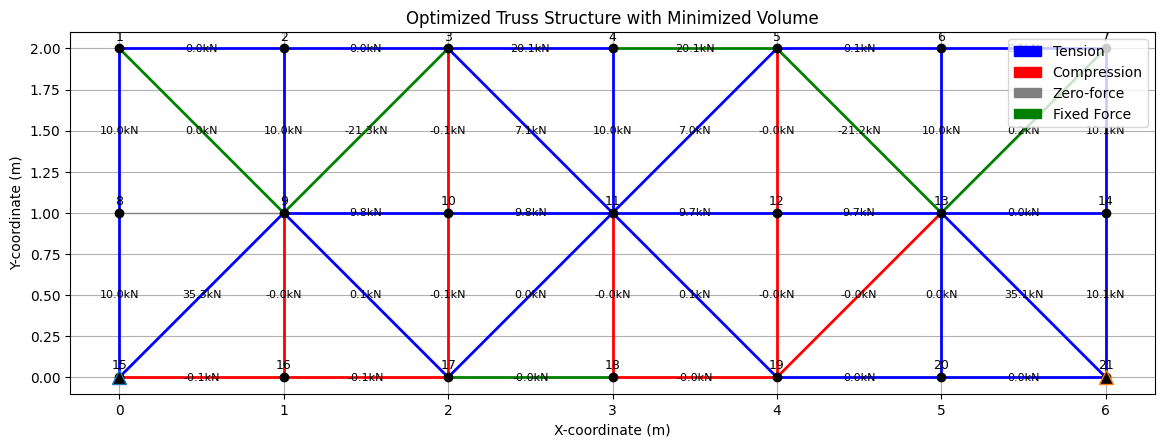

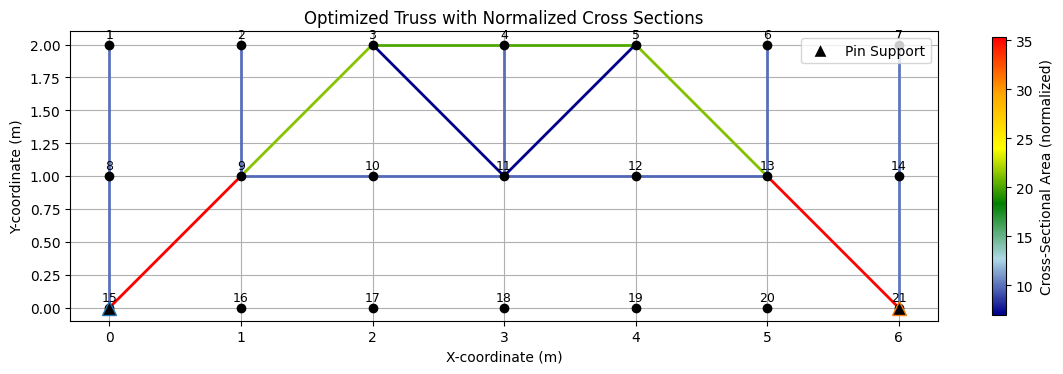

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [15, 4, 33, 34, 41, 42]  # List of member IDs to fix

# ------------------------- Part 1: Truss Definition -------------------------

class Truss:
    def __init__(self, columns=7, rows=3, load_magnitude=10):
        self.columns = columns
        self.rows = rows
        self.load_magnitude = load_magnitude
        self.nodes = {}
        self.members = {}
        self.support_reactions = {
            'R15x': None,   # Reaction at Node 15 in x-direction
            'R15y': None,   # Reaction at Node 15 in y-direction
            'R21x': None,   # Reaction at Node 21 in x-direction
            'R21y': None    # Reaction at Node 21 in y-direction
        }
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_external_loads()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for y in range(self.rows - 1, -1, -1):  # y=2 (top) to y=0 (bottom)
            for x in range(self.columns):       # x=0 to x=6
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members (e.g., (1,2) and (2,1))
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add horizontal members for each row
        for row in range(self.rows):
            start_node = 1 + row * self.columns
            for i in range(start_node, start_node + self.columns - 1):
                self.add_member(i, i + 1)

        # Add vertical members for each column
        for col in range(1, self.columns + 1):
            top_node = col
            middle_node = col + self.columns
            bottom_node = col + 2 * self.columns
            self.add_member(top_node, middle_node)
            self.add_member(middle_node, bottom_node)

        # Add diagonal members at specified middle nodes
        middle_nodes = [9, 11, 13]
        directions = [(-1, 1), (1, 1), (-1, -1), (1, -1)]
        for node in middle_nodes:
            x, y = self.nodes[node]
            for dx, dy in directions:
                diag_x, diag_y = x + dx, y + dy
                diag_node = self.find_node(diag_x, diag_y)
                if diag_node:
                    self.add_member(node, diag_node)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_external_loads(self):
        # Evenly distributed downward loads on top nodes (Nodes 1 to 7)
        self.external_loads = {node: (0, -self.load_magnitude) for node in range(1, self.columns + 1)}

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (0 to 50)
        self.gene_bounds = [(-50, 50) for _ in self.seed_fixed_forces]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Check equilibrium
        B_calculated = np.dot(A_ga, F_unknowns_ga)
        difference = B_calculated - B_ga
        tolerance = 1e-5  # Adjust tolerance as needed
        if np.any(np.abs(difference) > tolerance):
            # Equilibrium not satisfied, return a large fitness value
            return 1e10  # Large penalty
        else:
            # Reconstruct full member forces
            F_full_ga = np.zeros(self.num_members)
            for member_index in self.unknown_member_indices:
                unknown_idx = self.member_index_to_unknown[member_index]
                F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
            for i, m_id in enumerate(self.seed_fixed_member_ids):
                F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

            # Calculate total volume
            total_volume = 0.0
            for m_id, (start, end) in self.truss.members.items():
                x1, y1 = self.truss.nodes[start]
                x2, y2 = self.truss.nodes[end]
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                force_magnitude = abs(F_full_ga[m_id - 1])
                cross_sectional_area = force_magnitude / self.material_stress
                volume = cross_sectional_area * length
                total_volume += volume

            return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, (0, 0))
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node == 15:
                A_ga[eq_x, reaction_indices['R15x']] -= 1   # R15x
                A_ga[eq_y, reaction_indices['R15y']] -= 1   # R15y
            if node == 21:
                A_ga[eq_x, reaction_indices['R21x']] -= 1   # R21x
                A_ga[eq_y, reaction_indices['R21y']] -= 1   # R21y

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Optimized Truss -------------------------

def visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Extract reaction forces
    reaction_forces_ga = F_unknowns_ga[-num_reactions:]

    # Map reactions to indices
    reaction_indices = {}
    for idx, reaction in enumerate(truss.support_reactions):
        reaction_indices[reaction] = idx

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Annotate support reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='^', markersize=10, markerfacecolor='black')

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    plt.legend(handles=[tension_patch, compression_patch, zero_patch, fixed_patch], loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    # Setup equilibrium with optimized fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(optimized_fixed_member_forces.keys()),
        seed_fixed_forces=optimized_fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(optimized_fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = optimized_fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports without reactions
    # Node 15 (Pin Support)
    x15, y15 = truss.nodes[15]
    plt.plot(x15, y15, marker='^', markersize=10, markerfacecolor='black', label='Pin Support')
    # Node 21 (Pin Support)
    x21, y21 = truss.nodes[21]
    plt.plot(x21, y21, marker='^', markersize=10, markerfacecolor='black')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    pin_patch = Line2D([0], [0], marker='^', color='w', label='Pin Support',
                       markerfacecolor='black', markersize=10)
    plt.legend(handles=[pin_patch], loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Compute degree of indeterminacy
    truss.compute_degree_of_indeterminacy()
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Generate random initial forces for the fixed members between 0 and 50
    seed_fixed_forces = {m_id: random.uniform(0, 50) for m_id in fixed_member_ids}

    # Print selected fixed members and their initial random forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=500,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_optimized_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Definable code at the start

Random seeds are not set. Results may vary with each run.

Degree of Indeterminacy: 6

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 6):
  Member 34: -38.656719 kN
  Member 33: 7.878185 kN
  Member 21: 37.522090 kN
  Member 26: 13.045478 kN
  Member 42: 46.310591 kN
  Member 41: -33.851445 kN

Visualizing Initial Truss Structure...



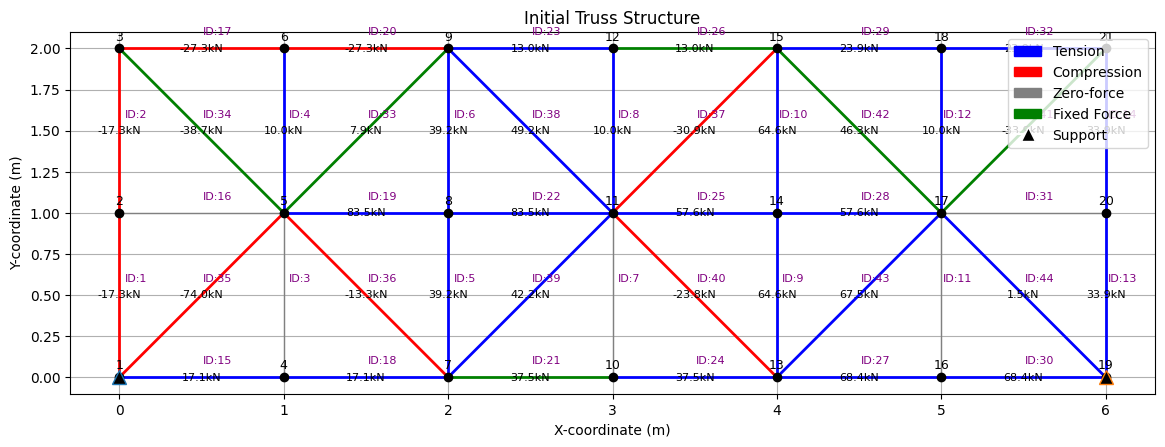


Starting Genetic Algorithm...

Generation 1: New Best Volume = 686.048914 cubic units
Current Fixed Member Forces:
  Member 34: -13.332820 kN
  Member 33: 22.056017 kN
  Member 21: -36.837591 kN
  Member 26: 1.925201 kN
  Member 42: 6.433820 kN
  Member 41: -15.554501 kN
--------------------------------------------------
Generation 2: New Best Volume = 603.644095 cubic units
Current Fixed Member Forces:
  Member 34: -8.539568 kN
  Member 33: 19.032892 kN
  Member 21: 17.025938 kN
  Member 26: 24.260963 kN
  Member 42: -14.099124 kN
  Member 41: -7.936325 kN
--------------------------------------------------
Generation 4: New Best Volume = 593.669053 cubic units
Current Fixed Member Forces:
  Member 34: 11.448870 kN
  Member 33: 16.663542 kN
  Member 21: -28.217791 kN
  Member 26: 1.744732 kN
  Member 42: -17.981415 kN
  Member 41: 5.111558 kN
--------------------------------------------------
Generation 5: New Best Volume = 415.665796 cubic units
Current Fixed Member Forces:
  Member 

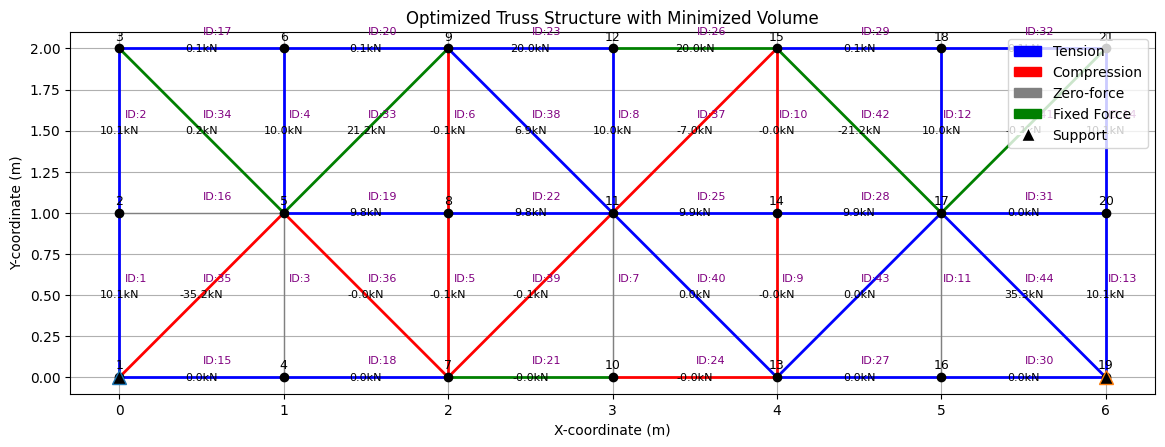

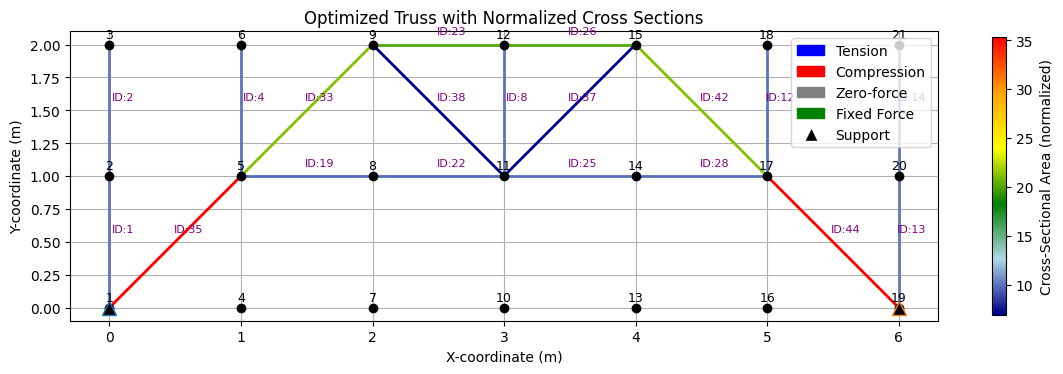

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [34, 33, 21, 26, 42, 41]  # List of member IDs to fix

# Truss Configuration
COLUMNS = 7  # Number of columns of nodes
ROWS = 3     # Number of rows of nodes

# Load Nodes: {node_id: [Fx, Fy], ...}
# Nodes 3, 6, 9, 12, 15, 18, 21 have a load of [0, -10]
LOAD_NODES = {
    3: [0, -10],
    6: [0, -10],
    9: [0, -10],
    12: [0, -10],
    15: [0, -10],
    18: [0, -10],
    21: [0, -10]
}

# Support Nodes: {node_id: [Restrain_x (1 or 0), Restrain_y (1 or 0)], ...}
# Nodes 1 and 19 are supports restrained in x and y
SUPPORT_NODES = {
    1: [1, 1],
    19: [1, 1]
}

# ------------------------- Part 1: Truss Definition -------------------------

class Truss:
    def __init__(self, columns=COLUMNS, rows=ROWS, load_nodes=LOAD_NODES, support_nodes=SUPPORT_NODES):
        self.columns = columns
        self.rows = rows
        self.nodes = {}
        self.members = {}
        self.external_loads = load_nodes  # {node_id: [Fx, Fy], ...}
        self.support_nodes = support_nodes  # {node_id: [Restrain_x, Restrain_y], ...}
        self.support_reactions = {}  # Will be populated based on support_nodes
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_support_reactions()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for x in range(self.columns):       # x=0 to x=COLUMNS-1
            for y in range(self.rows):      # y=0 to y=ROWS-1
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add vertical members
        for x in range(self.columns):
            for y in range(self.rows - 1):
                node_start = x * self.rows + y + 1
                node_end = node_start + 1
                self.add_member(node_start, node_end)

        # Add horizontal members
        for x in range(self.columns - 1):
            for y in range(self.rows):
                node_start = x * self.rows + y + 1
                node_end = (x + 1) * self.rows + y + 1
                self.add_member(node_start, node_end)

        # Add diagonal members at special nodes
        for x in range(self.columns):
            for y in range(self.rows):
                # Identify special nodes (every second node in every second column)
                if x % 2 == 1 and y % 2 == 1:
                    current_node = x * self.rows + y + 1
                    # Top-right diagonal
                    if x < self.columns - 1 and y < self.rows - 1:
                        node_tr = (x + 1) * self.rows + y + 2
                        self.add_member(current_node, node_tr)
                    # Top-left diagonal
                    if x > 0 and y < self.rows - 1:
                        node_tl = (x - 1) * self.rows + y + 2
                        self.add_member(current_node, node_tl)
                    # Bottom-left diagonal
                    if x > 0 and y > 0:
                        node_bl = (x - 1) * self.rows + y
                        self.add_member(current_node, node_bl)
                    # Bottom-right diagonal
                    if x < self.columns - 1 and y > 0:
                        node_br = (x + 1) * self.rows + y
                        self.add_member(current_node, node_br)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_support_reactions(self):
        # For each support node, define reactions based on restraints
        self.support_reactions = {}
        for node_id, restraints in self.support_nodes.items():
            restrain_x, restrain_y = restraints
            if restrain_x:
                self.support_reactions[f'R{node_id}x'] = None
            if restrain_y:
                self.support_reactions[f'R{node_id}y'] = None

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (-50 to 50)
        self.gene_bounds = [(-50, 50) for _ in self.seed_fixed_forces]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Check equilibrium
        B_calculated = np.dot(A_ga, F_unknowns_ga)
        difference = B_calculated - B_ga
        tolerance = 1e-5  # Adjust tolerance as needed
        if np.any(np.abs(difference) > tolerance):
            # Equilibrium not satisfied, return a large fitness value
            return 1e10  # Large penalty
        else:
            # Reconstruct full member forces
            F_full_ga = np.zeros(self.num_members)
            for member_index in self.unknown_member_indices:
                unknown_idx = self.member_index_to_unknown[member_index]
                F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
            for i, m_id in enumerate(self.seed_fixed_member_ids):
                F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

            # Calculate total volume
            total_volume = 0.0
            for m_id, (start, end) in self.truss.members.items():
                x1, y1 = self.truss.nodes[start]
                x2, y2 = self.truss.nodes[end]
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                force_magnitude = abs(F_full_ga[m_id - 1])
                cross_sectional_area = force_magnitude / self.material_stress
                volume = cross_sectional_area * length
                total_volume += volume

            return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, [0, 0])
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node in self.truss.support_nodes:
                restraints = self.truss.support_nodes[node]
                restrain_x, restrain_y = restraints
                if restrain_x:
                    reaction_name = f'R{node}x'
                    A_ga[eq_x, reaction_indices[reaction_name]] -= 1
                if restrain_y:
                    reaction_name = f'R{node}y'
                    A_ga[eq_y, reaction_indices[reaction_name]] -= 1

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Truss -------------------------

def visualize_truss(truss, fixed_member_forces, title="Truss Structure"):
    """
    Visualize the truss structure with member forces and Member IDs.
    """
    # Setup equilibrium with given fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(fixed_member_forces.keys()),
        seed_fixed_forces=fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = fixed_member_forces[m_id]

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            if force > 0:
                color = tension_color
                linewidth = 2
            elif force < 0:
                color = compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

        # Annotate the Member ID slightly offset from the midpoint
        offset = 0.1  # Adjust as needed for clarity
        plt.text(x_mid + offset, y_mid + offset, f"ID:{m_id}",
                 color='purple', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports
    support_plotted = False
    for node_id, restraints in truss.support_nodes.items():
        x, y = truss.nodes[node_id]
        plt.plot(x, y, marker='^', markersize=10, markerfacecolor='black',
                 label='Support' if not support_plotted else "")
        support_plotted = True

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    handles = [tension_patch, compression_patch, zero_patch, fixed_patch]
    if support_plotted:
        pin_patch = Line2D([0], [0], marker='^', color='w', label='Support',
                           markerfacecolor='black', markersize=10)
        handles.append(pin_patch)
    plt.legend(handles=handles, loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    """
    Plot the truss with cross-sectional areas colored based on normalized values.
    """
    # Setup equilibrium with given fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(fixed_member_forces.keys()),
        seed_fixed_forces=fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

        # Annotate the Member ID slightly offset from the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        offset = 0.1  # Adjust as needed for clarity
        plt.text(x_mid + offset, y_mid + offset, f"ID:{m_id}",
                 color='purple', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports
    support_plotted = False
    for node_id, restraints in truss.support_nodes.items():
        x, y = truss.nodes[node_id]
        plt.plot(x, y, marker='^', markersize=10, markerfacecolor='black',
                 label='Support' if not support_plotted else "")
        support_plotted = True

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    handles = []
    tension_patch = mpatches.Patch(color='blue', label='Tension')
    compression_patch = mpatches.Patch(color='red', label='Compression')
    zero_patch = mpatches.Patch(color='gray', label='Zero-force')
    fixed_patch = mpatches.Patch(color='green', label='Fixed Force')
    handles.extend([tension_patch, compression_patch, zero_patch, fixed_patch])
    if support_plotted:
        pin_patch = Line2D([0], [0], marker='^', color='w', label='Support',
                           markerfacecolor='black', markersize=10)
        handles.append(pin_patch)
    plt.legend(handles=handles, loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Compute degree of indeterminacy
    truss.compute_degree_of_indeterminacy()
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Generate random initial forces for the fixed members between -50 and 50
    seed_fixed_forces = {m_id: random.uniform(-50, 50) for m_id in fixed_member_ids}

    # Print selected fixed members and their initial random forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nVisualizing Initial Truss Structure...\n")

    # Visualize the initial truss before optimization
    visualize_truss(truss, seed_fixed_forces, title="Initial Truss Structure")

    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=500,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Colour of bars switch

Random seeds are not set. Results may vary with each run.

Degree of Indeterminacy: 6

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 6):
  Member 34: -29.158558 kN
  Member 33: 30.119312 kN
  Member 21: 24.576972 kN
  Member 26: -17.104625 kN
  Member 42: -14.546618 kN
  Member 41: 8.880176 kN

Visualizing Initial Truss Structure...



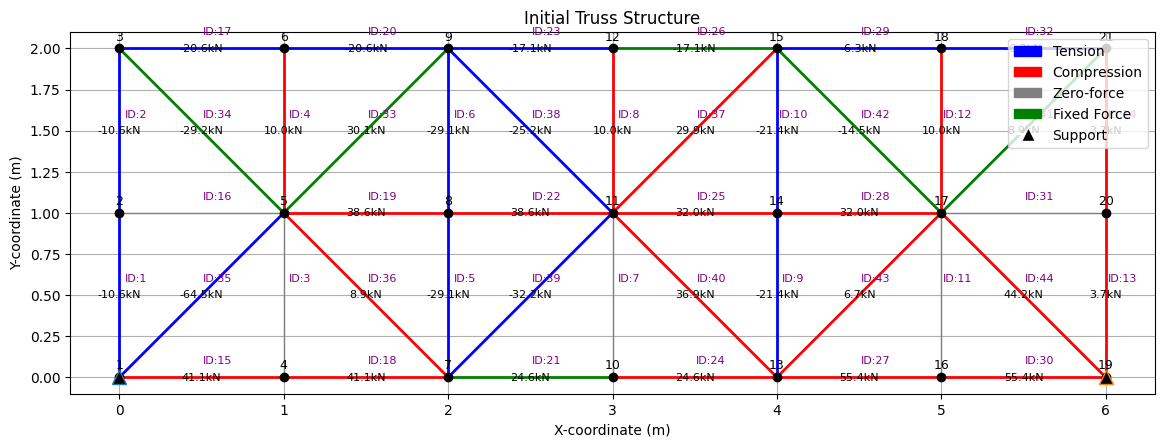


Starting Genetic Algorithm...

Generation 1: New Best Volume = 505.344400 cubic units
Current Fixed Member Forces:
  Member 34: -5.514236 kN
  Member 33: 24.120074 kN
  Member 21: 3.364582 kN
  Member 26: 26.294350 kN
  Member 42: -34.552461 kN
  Member 41: 2.372646 kN
--------------------------------------------------
Generation 3: New Best Volume = 473.337570 cubic units
Current Fixed Member Forces:
  Member 34: -6.683886 kN
  Member 33: 24.120074 kN
  Member 21: 3.364582 kN
  Member 26: 19.964246 kN
  Member 42: -34.552461 kN
  Member 41: 2.370990 kN
--------------------------------------------------
Generation 4: New Best Volume = 441.770710 cubic units
Current Fixed Member Forces:
  Member 34: -3.063318 kN
  Member 33: 28.672596 kN
  Member 21: 3.364582 kN
  Member 26: 19.964246 kN
  Member 42: -34.552461 kN
  Member 41: 6.625272 kN
--------------------------------------------------
Generation 5: New Best Volume = 419.852250 cubic units
Current Fixed Member Forces:
  Member 34: 6

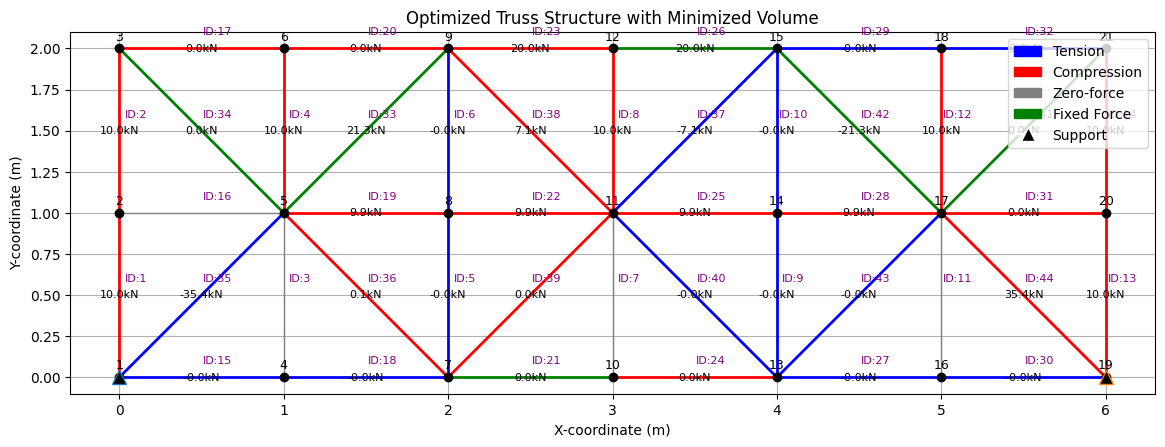

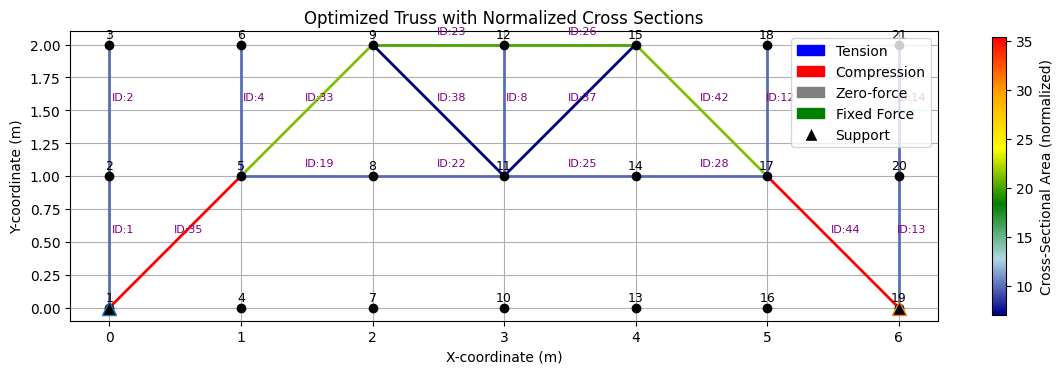

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [34, 33, 21, 26, 42, 41]  # List of member IDs to fix

# Truss Configuration
COLUMNS = 7  # Number of columns of nodes
ROWS = 3     # Number of rows of nodes

# Load Nodes: {node_id: [Fx, Fy], ...}
# Nodes 3, 6, 9, 12, 15, 18, 21 have a load of [0, -10]
LOAD_NODES = {
    3: [0, -10],
    6: [0, -10],
    9: [0, -10],
    12: [0, -10],
    15: [0, -10],
    18: [0, -10],
    21: [0, -10]
}

# Support Nodes: {node_id: [Restrain_x (1 or 0), Restrain_y (1 or 0)], ...}
# Nodes 1 and 19 are supports restrained in x and y
SUPPORT_NODES = {
    1: [1, 1],
    19: [1, 1]
}

# ------------------------- Part 1: Truss Definition -------------------------

class Truss:
    def __init__(self, columns=COLUMNS, rows=ROWS, load_nodes=LOAD_NODES, support_nodes=SUPPORT_NODES):
        self.columns = columns
        self.rows = rows
        self.nodes = {}
        self.members = {}
        self.external_loads = load_nodes  # {node_id: [Fx, Fy], ...}
        self.support_nodes = support_nodes  # {node_id: [Restrain_x, Restrain_y], ...}
        self.support_reactions = {}  # Will be populated based on support_nodes
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_support_reactions()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for x in range(self.columns):       # x=0 to x=COLUMNS-1
            for y in range(self.rows):      # y=0 to y=ROWS-1
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add vertical members
        for x in range(self.columns):
            for y in range(self.rows - 1):
                node_start = x * self.rows + y + 1
                node_end = node_start + 1
                self.add_member(node_start, node_end)

        # Add horizontal members
        for x in range(self.columns - 1):
            for y in range(self.rows):
                node_start = x * self.rows + y + 1
                node_end = (x + 1) * self.rows + y + 1
                self.add_member(node_start, node_end)

        # Add diagonal members at special nodes
        for x in range(self.columns):
            for y in range(self.rows):
                # Identify special nodes (every second node in every second column)
                if x % 2 == 1 and y % 2 == 1:
                    current_node = x * self.rows + y + 1
                    # Top-right diagonal
                    if x < self.columns - 1 and y < self.rows - 1:
                        node_tr = (x + 1) * self.rows + y + 2
                        self.add_member(current_node, node_tr)
                    # Top-left diagonal
                    if x > 0 and y < self.rows - 1:
                        node_tl = (x - 1) * self.rows + y + 2
                        self.add_member(current_node, node_tl)
                    # Bottom-left diagonal
                    if x > 0 and y > 0:
                        node_bl = (x - 1) * self.rows + y
                        self.add_member(current_node, node_bl)
                    # Bottom-right diagonal
                    if x < self.columns - 1 and y > 0:
                        node_br = (x + 1) * self.rows + y
                        self.add_member(current_node, node_br)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_support_reactions(self):
        # For each support node, define reactions based on restraints
        self.support_reactions = {}
        for node_id, restraints in self.support_nodes.items():
            restrain_x, restrain_y = restraints
            if restrain_x:
                self.support_reactions[f'R{node_id}x'] = None
            if restrain_y:
                self.support_reactions[f'R{node_id}y'] = None

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (-50 to 50)
        self.gene_bounds = [(-50, 50) for _ in self.seed_fixed_forces]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Check equilibrium
        B_calculated = np.dot(A_ga, F_unknowns_ga)
        difference = B_calculated - B_ga
        tolerance = 1e-5  # Adjust tolerance as needed
        if np.any(np.abs(difference) > tolerance):
            # Equilibrium not satisfied, return a large fitness value
            return 1e10  # Large penalty
        else:
            # Reconstruct full member forces
            F_full_ga = np.zeros(self.num_members)
            for member_index in self.unknown_member_indices:
                unknown_idx = self.member_index_to_unknown[member_index]
                F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
            for i, m_id in enumerate(self.seed_fixed_member_ids):
                F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

            # Calculate total volume
            total_volume = 0.0
            for m_id, (start, end) in self.truss.members.items():
                x1, y1 = self.truss.nodes[start]
                x2, y2 = self.truss.nodes[end]
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                force_magnitude = abs(F_full_ga[m_id - 1])
                cross_sectional_area = force_magnitude / self.material_stress
                volume = cross_sectional_area * length
                total_volume += volume

            return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, [0, 0])
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node in self.truss.support_nodes:
                restraints = self.truss.support_nodes[node]
                restrain_x, restrain_y = restraints
                if restrain_x:
                    reaction_name = f'R{node}x'
                    A_ga[eq_x, reaction_indices[reaction_name]] -= 1
                if restrain_y:
                    reaction_name = f'R{node}y'
                    A_ga[eq_y, reaction_indices[reaction_name]] -= 1

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Truss -------------------------

def visualize_truss(truss, fixed_member_forces, title="Truss Structure"):
    """
    Visualize the truss structure with member forces and Member IDs.
    """
    # Setup equilibrium with given fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(fixed_member_forces.keys()),
        seed_fixed_forces=fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = fixed_member_forces[m_id]

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            # Swap the interpretation: Positive = Compression, Negative = Tension
            if force > 0:
                color = compression_color  # Previously tension_color
                linewidth = 2
            elif force < 0:
                color = tension_color  # Previously compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

        # Annotate the Member ID slightly offset from the midpoint
        offset = 0.1  # Adjust as needed for clarity
        plt.text(x_mid + offset, y_mid + offset, f"ID:{m_id}",
                 color='purple', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports
    support_plotted = False
    for node_id, restraints in truss.support_nodes.items():
        x, y = truss.nodes[node_id]
        plt.plot(x, y, marker='^', markersize=10, markerfacecolor='black',
                 label='Support' if not support_plotted else "")
        support_plotted = True

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')  # Now correctly represents negative forces
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')  # Now correctly represents positive forces
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    handles = [tension_patch, compression_patch, zero_patch, fixed_patch]
    if support_plotted:
        pin_patch = Line2D([0], [0], marker='^', color='w', label='Support',
                           markerfacecolor='black', markersize=10)
        handles.append(pin_patch)
    plt.legend(handles=handles, loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    """
    Plot the truss with cross-sectional areas colored based on normalized values.
    """
    # Setup equilibrium with given fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(fixed_member_forces.keys()),
        seed_fixed_forces=fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

        # Annotate the Member ID slightly offset from the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        offset = 0.1  # Adjust as needed for clarity
        plt.text(x_mid + offset, y_mid + offset, f"ID:{m_id}",
                 color='purple', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports
    support_plotted = False
    for node_id, restraints in truss.support_nodes.items():
        x, y = truss.nodes[node_id]
        plt.plot(x, y, marker='^', markersize=10, markerfacecolor='black',
                 label='Support' if not support_plotted else "")
        support_plotted = True

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    handles = []
    tension_patch = mpatches.Patch(color='blue', label='Tension')
    compression_patch = mpatches.Patch(color='red', label='Compression')
    zero_patch = mpatches.Patch(color='gray', label='Zero-force')
    fixed_patch = mpatches.Patch(color='green', label='Fixed Force')
    handles.extend([tension_patch, compression_patch, zero_patch, fixed_patch])
    if support_plotted:
        pin_patch = Line2D([0], [0], marker='^', color='w', label='Support',
                           markerfacecolor='black', markersize=10)
        handles.append(pin_patch)
    plt.legend(handles=handles, loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Compute degree of indeterminacy
    truss.compute_degree_of_indeterminacy()
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Generate random initial forces for the fixed members between -50 and 50
    seed_fixed_forces = {m_id: random.uniform(-50, 50) for m_id in fixed_member_ids}

    # Print selected fixed members and their initial random forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nVisualizing Initial Truss Structure...\n")

    # Visualize the initial truss before optimization
    visualize_truss(truss, seed_fixed_forces, title="Initial Truss Structure")

    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=500,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")


## Trying 4 cells

Random seeds are not set. Results may vary with each run.

Degree of Indeterminacy: 8

--- Genetic Algorithm Optimization ---

Selected Fixed Members (Total 8):
  Member 44: 49.948737 kN
  Member 43: 29.632484 kN
  Member 48: -14.986809 kN
  Member 47: -14.132376 kN
  Member 31: 33.973225 kN
  Member 36: 12.555499 kN
  Member 56: 28.963306 kN
  Member 55: 24.585432 kN

Visualizing Initial Truss Structure...



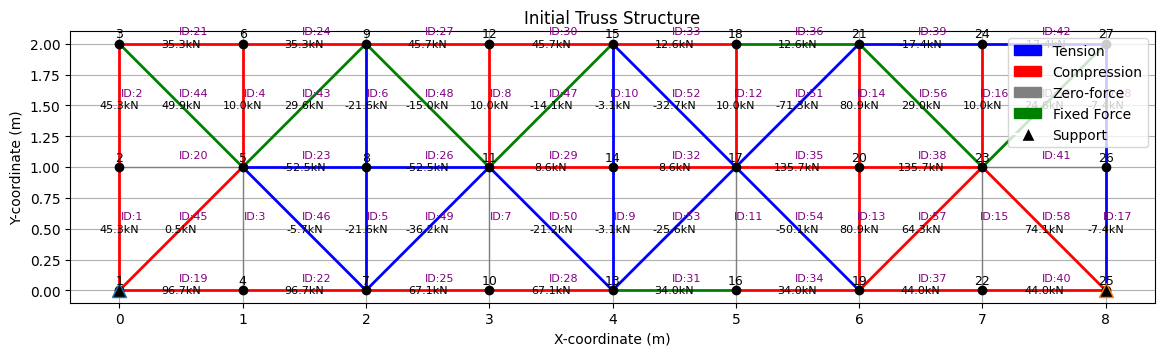


Starting Genetic Algorithm...

Generation 1: New Best Volume = 931.195346 cubic units
Current Fixed Member Forces:
  Member 44: -1.658720 kN
  Member 43: 32.036319 kN
  Member 48: 1.878393 kN
  Member 47: -11.406438 kN
  Member 31: -1.307746 kN
  Member 36: 30.340404 kN
  Member 56: -27.171574 kN
  Member 55: -3.462779 kN
--------------------------------------------------
Generation 2: New Best Volume = 749.923572 cubic units
Current Fixed Member Forces:
  Member 44: -1.625715 kN
  Member 43: 40.440872 kN
  Member 48: 7.720702 kN
  Member 47: 0.791287 kN
  Member 31: -10.198438 kN
  Member 36: 35.528311 kN
  Member 56: -34.503620 kN
  Member 55: -5.335948 kN
--------------------------------------------------
Generation 7: New Best Volume = 743.705982 cubic units
Current Fixed Member Forces:
  Member 44: 7.548476 kN
  Member 43: 26.811215 kN
  Member 48: 15.827546 kN
  Member 47: 2.470911 kN
  Member 31: -1.805524 kN
  Member 36: 34.898364 kN
  Member 56: -23.006674 kN
  Member 55: 0.8

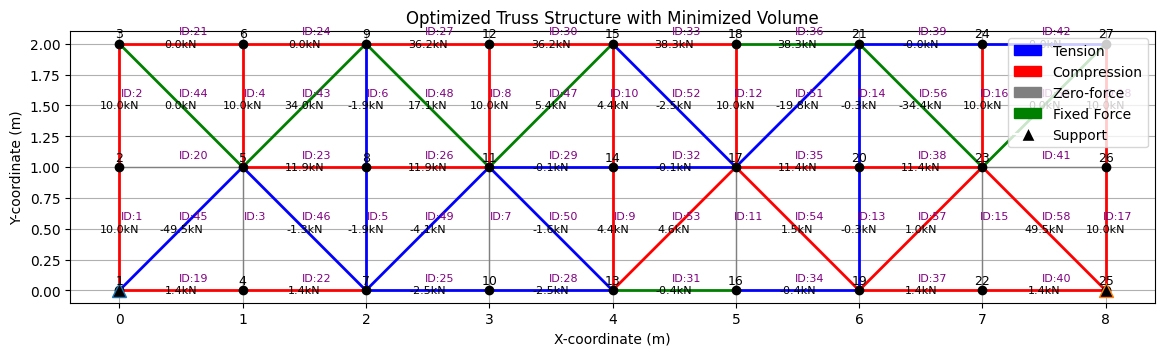

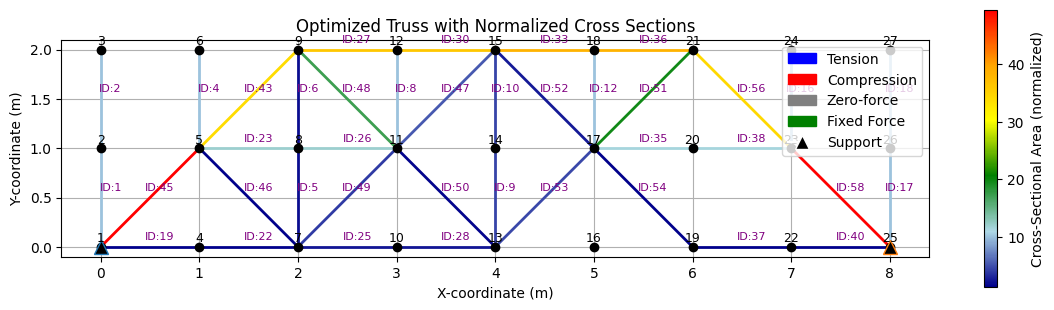

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import random
import copy

# ------------------------- Configuration -------------------------

USE_SEED = False  # Set to False to disable fixed random seed

# New Configuration Options
SPECIFY_FIXED_MEMBERS = True  # Set to True to specify fixed members manually
SPECIFIED_FIXED_MEMBER_IDS = [44, 43, 48, 47, 31, 36, 56, 55]  # List of member IDs to fix

# Truss Configuration
COLUMNS = 9  # Number of columns of nodes
ROWS = 3     # Number of rows of nodes

# Load Nodes: {node_id: [Fx, Fy], ...}
# Nodes 3, 6, 9, 12, 15, 18, 21 have a load of [0, -10]
LOAD_NODES = {
    3: [0, -10],
    6: [0, -10],
    9: [0, -10],
    12: [0, -10],
    15: [0, -10],
    18: [0, -10],
    21: [0, -10],
    24: [0, -10],
    27: [0, -10]
}

# Support Nodes: {node_id: [Restrain_x (1 or 0), Restrain_y (1 or 0)], ...}
# Nodes 1 and 19 are supports restrained in x and y
SUPPORT_NODES = {
    1: [1, 1],
    25: [1, 1]
}

# ------------------------- Part 1: Truss Definition -------------------------

class Truss:
    def __init__(self, columns=COLUMNS, rows=ROWS, load_nodes=LOAD_NODES, support_nodes=SUPPORT_NODES):
        self.columns = columns
        self.rows = rows
        self.nodes = {}
        self.members = {}
        self.external_loads = load_nodes  # {node_id: [Fx, Fy], ...}
        self.support_nodes = support_nodes  # {node_id: [Restrain_x, Restrain_y], ...}
        self.support_reactions = {}  # Will be populated based on support_nodes
        self.fixed_member_ids = []  # To be set dynamically based on degree of indeterminacy
        self.degree_of_indeterminacy = 0
        self.direction_cosines_cache = {}
        self.initialize_truss()

    def initialize_truss(self):
        self.define_nodes()
        self.define_members()
        self.define_support_reactions()
        self.compute_degree_of_indeterminacy()

    def define_nodes(self):
        node_id = 1
        for x in range(self.columns):       # x=0 to x=COLUMNS-1
            for y in range(self.rows):      # y=0 to y=ROWS-1
                self.nodes[node_id] = (x, y)
                node_id += 1

    def add_member(self, start, end):
        if start not in self.nodes or end not in self.nodes:
            print(f"Skipping member ({start}, {end}) - Invalid node number.")
            return
        # Avoid duplicate members
        if not any(
            (start == existing_start and end == existing_end) or
            (start == existing_end and end == existing_start)
            for existing_start, existing_end in self.members.values()
        ):
            self.members[len(self.members) + 1] = (start, end)

    def define_members(self):
        # Add vertical members
        for x in range(self.columns):
            for y in range(self.rows - 1):
                node_start = x * self.rows + y + 1
                node_end = node_start + 1
                self.add_member(node_start, node_end)

        # Add horizontal members
        for x in range(self.columns - 1):
            for y in range(self.rows):
                node_start = x * self.rows + y + 1
                node_end = (x + 1) * self.rows + y + 1
                self.add_member(node_start, node_end)

        # Add diagonal members at special nodes
        for x in range(self.columns):
            for y in range(self.rows):
                # Identify special nodes (every second node in every second column)
                if x % 2 == 1 and y % 2 == 1:
                    current_node = x * self.rows + y + 1
                    # Top-right diagonal
                    if x < self.columns - 1 and y < self.rows - 1:
                        node_tr = (x + 1) * self.rows + y + 2
                        self.add_member(current_node, node_tr)
                    # Top-left diagonal
                    if x > 0 and y < self.rows - 1:
                        node_tl = (x - 1) * self.rows + y + 2
                        self.add_member(current_node, node_tl)
                    # Bottom-left diagonal
                    if x > 0 and y > 0:
                        node_bl = (x - 1) * self.rows + y
                        self.add_member(current_node, node_bl)
                    # Bottom-right diagonal
                    if x < self.columns - 1 and y > 0:
                        node_br = (x + 1) * self.rows + y
                        self.add_member(current_node, node_br)

    def find_node(self, x, y):
        for nid, coord in self.nodes.items():
            if coord == (x, y):
                return nid
        return None

    def define_support_reactions(self):
        # For each support node, define reactions based on restraints
        self.support_reactions = {}
        for node_id, restraints in self.support_nodes.items():
            restrain_x, restrain_y = restraints
            if restrain_x:
                self.support_reactions[f'R{node_id}x'] = None
            if restrain_y:
                self.support_reactions[f'R{node_id}y'] = None

    def compute_degree_of_indeterminacy(self):
        num_reactions = len(self.support_reactions)
        num_members = len(self.members)
        num_nodes = len(self.nodes)
        self.degree_of_indeterminacy = num_members + num_reactions - 2 * num_nodes

    def direction_cosines(self, start, end):
        key = tuple(sorted((start, end)))
        if key in self.direction_cosines_cache:
            return self.direction_cosines_cache[key]
        x1, y1 = self.nodes[start]
        x2, y2 = self.nodes[end]
        delta_x = x2 - x1
        delta_y = y2 - y1
        length = np.sqrt(delta_x**2 + delta_y**2)
        if length == 0:
            raise ValueError(f"Zero length member between nodes {start} and {end}.")
        cos_theta = delta_x / length
        sin_theta = delta_y / length
        self.direction_cosines_cache[key] = (cos_theta, sin_theta)
        return cos_theta, sin_theta

# ------------------------- Part 2: Genetic Algorithm for Minimum Truss Volume -------------------------

class GeneticAlgorithmOptimizer:
    def __init__(self, truss, seed_fixed_member_ids, seed_fixed_forces,
                 material_stress=1, population_size=200, generations=200,
                 tournament_size=3, crossover_rate=0.8, mutation_rate=0.5, mutation_amount=10, elitism=True):
        self.truss = truss
        self.seed_fixed_member_ids = seed_fixed_member_ids
        self.seed_fixed_forces = seed_fixed_forces
        self.material_stress = material_stress

        # Genetic Algorithm Parameters
        self.POPULATION_SIZE = population_size
        self.GENERATIONS = generations
        self.TOURNAMENT_SIZE = tournament_size
        self.CROSSOVER_RATE = crossover_rate
        self.MUTATION_RATE = mutation_rate
        self.MUTATION_AMOUNT = mutation_amount
        self.elitism = elitism

        # Define gene bounds (-50 to 50)
        self.gene_bounds = [(-50, 50) for _ in self.seed_fixed_forces]

        # Create mappings
        self.fixed_member_indices = [m - 1 for m in self.seed_fixed_member_ids]
        self.unknown_member_indices = [
            i for i in range(len(truss.members)) if i not in self.fixed_member_indices
        ]
        self.num_reactions = len(truss.support_reactions)
        self.num_members = len(truss.members)
        self.num_unknowns_ga = len(self.unknown_member_indices) + self.num_reactions

        # Mapping from member index to unknown index
        self.member_index_to_unknown = {
            i: idx for idx, i in enumerate(self.unknown_member_indices)
        }

        # Mapping for reaction indices
        self.reaction_indices = {}
        for idx, reaction in enumerate(self.truss.support_reactions):
            self.reaction_indices[reaction] = len(self.unknown_member_indices) + idx

    def initialize_population(self):
        population = []
        for _ in range(self.POPULATION_SIZE):
            individual = [
                random.uniform(low, high) for (low, high) in self.gene_bounds
            ]
            population.append(individual)
        return population

    def compute_total_volume(self, current_fixed_member_forces):
        A_ga, B_ga = self.setup_equilibrium(current_fixed_member_forces)
        try:
            F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
            equilibrium_satisfied_ga = True
        except np.linalg.LinAlgError:
            F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)
            equilibrium_satisfied_ga = False

        # Check equilibrium
        B_calculated = np.dot(A_ga, F_unknowns_ga)
        difference = B_calculated - B_ga
        tolerance = 1e-5  # Adjust tolerance as needed
        if np.any(np.abs(difference) > tolerance):
            # Equilibrium not satisfied, return a large fitness value
            return 1e10  # Large penalty
        else:
            # Reconstruct full member forces
            F_full_ga = np.zeros(self.num_members)
            for member_index in self.unknown_member_indices:
                unknown_idx = self.member_index_to_unknown[member_index]
                F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
            for i, m_id in enumerate(self.seed_fixed_member_ids):
                F_full_ga[m_id - 1] = current_fixed_member_forces[m_id]

            # Calculate total volume
            total_volume = 0.0
            for m_id, (start, end) in self.truss.members.items():
                x1, y1 = self.truss.nodes[start]
                x2, y2 = self.truss.nodes[end]
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                force_magnitude = abs(F_full_ga[m_id - 1])
                cross_sectional_area = force_magnitude / self.material_stress
                volume = cross_sectional_area * length
                total_volume += volume

            return total_volume

    def setup_equilibrium(self, current_fixed_member_forces):
        num_members = self.num_members
        num_reactions = self.num_reactions
        num_nodes = len(self.truss.nodes)
        equations_per_node = 2
        total_equations = num_nodes * equations_per_node
        total_unknowns = self.num_unknowns_ga

        A_ga = np.zeros((total_equations, total_unknowns))
        B_ga = np.zeros(total_equations)

        # Map reactions to indices
        reaction_indices = self.reaction_indices

        for node in self.truss.nodes:
            eq_x = (node - 1) * 2
            eq_y = eq_x + 1

            # Assign external loads
            load = self.truss.external_loads.get(node, [0, 0])
            B_ga[eq_x] += load[0]
            B_ga[eq_y] += load[1]

            # Iterate through connected members
            for m_id, (start, end) in self.truss.members.items():
                member_index = m_id - 1
                if node == start or node == end:
                    other = end if node == start else start
                    cos_theta, sin_theta = self.truss.direction_cosines(node, other)
                    coef_x = cos_theta if node == start else -cos_theta
                    coef_y = sin_theta if node == start else -sin_theta

                    if m_id in current_fixed_member_forces:
                        fixed_force = current_fixed_member_forces[m_id]
                        B_ga[eq_x] -= coef_x * fixed_force
                        B_ga[eq_y] -= coef_y * fixed_force
                    else:
                        if member_index in self.member_index_to_unknown:
                            unknown_idx = self.member_index_to_unknown[member_index]
                            A_ga[eq_x, unknown_idx] += coef_x
                            A_ga[eq_y, unknown_idx] += coef_y

            # Assign support reactions
            if node in self.truss.support_nodes:
                restraints = self.truss.support_nodes[node]
                restrain_x, restrain_y = restraints
                if restrain_x:
                    reaction_name = f'R{node}x'
                    A_ga[eq_x, reaction_indices[reaction_name]] -= 1
                if restrain_y:
                    reaction_name = f'R{node}y'
                    A_ga[eq_y, reaction_indices[reaction_name]] -= 1

        return A_ga, B_ga

    def fitness(self, individual):
        current_fixed_member_forces = {
            m: individual[i] for i, m in enumerate(self.seed_fixed_member_ids)
        }
        total_vol = self.compute_total_volume(current_fixed_member_forces)
        return total_vol  # Objective: minimize total volume

    def tournament_selection(self, population, scores):
        selected = []
        for _ in range(self.POPULATION_SIZE):
            aspirants = random.sample(range(len(population)), self.TOURNAMENT_SIZE)
            aspirant_scores = [scores[i] for i in aspirants]
            winner = aspirants[np.argmin(aspirant_scores)]
            selected.append(copy.deepcopy(population[winner]))
        return selected

    def mutate(self, individual, generation):
        # Adaptive mutation amount: decreases over generations
        adaptive_mutation_amount = self.MUTATION_AMOUNT * (1 - generation / self.GENERATIONS)
        for i in range(len(individual)):
            if random.random() < self.MUTATION_RATE:
                mutation = random.uniform(-adaptive_mutation_amount, adaptive_mutation_amount)
                individual[i] += mutation
                # Clamp the gene within bounds
                low, high = self.gene_bounds[i]
                individual[i] = max(low, min(individual[i], high))
        return individual

    def run(self):
        population = self.initialize_population()
        best_volume = float('inf')
        best_individual = None

        for gen in range(1, self.GENERATIONS + 1):
            # Evaluate fitness
            scores = [self.fitness(ind) for ind in population]
            # Find the best individual in current generation
            min_score = min(scores)
            min_index = scores.index(min_score)
            current_best_individual = population[min_index]
            current_best_volume = min_score

            # Update global best
            if current_best_volume < best_volume:
                best_volume = current_best_volume
                best_individual = copy.deepcopy(current_best_individual)
                print(f"Generation {gen}: New Best Volume = {best_volume:.6f} cubic units")
                print("Current Fixed Member Forces:")
                for i, m in enumerate(self.seed_fixed_member_ids):
                    print(f"  Member {m}: {best_individual[i]:.6f} kN")
                print("-" * 50)

            # Selection
            selected = self.tournament_selection(population, scores)

            # Crossover and Mutation
            next_generation = []

            # Elitism: carry over the best individual
            if self.elitism:
                next_generation.append(best_individual)

            while len(next_generation) < self.POPULATION_SIZE:
                parent1 = random.choice(selected)
                parent2 = random.choice(selected)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1, gen)
                child2 = self.mutate(child2, gen)
                next_generation.extend([child1, child2])

            population = next_generation[:self.POPULATION_SIZE]

        return best_individual, best_volume

    def crossover(self, parent1, parent2):
        if random.random() < self.CROSSOVER_RATE:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

# ------------------------- Part 3: Visualization of Truss -------------------------

def visualize_truss(truss, fixed_member_forces, title="Truss Structure"):
    """
    Visualize the truss structure with member forces and Member IDs.
    """
    # Setup equilibrium with given fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(fixed_member_forces.keys()),
        seed_fixed_forces=fixed_member_forces,
        material_stress=1  # Assuming material_stress is 1 for consistency
    )

    A_ga, B_ga = optimizer.setup_equilibrium(fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = fixed_member_forces[m_id]

    # Plot the Truss
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Define colors for different member statuses
    tension_color = 'blue'
    compression_color = 'red'
    zero_color = 'gray'
    fixed_color = 'green'

    # Plot each member
    for m_id, (start, end) in truss.members.items():
        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        force = F_full_ga[m_id - 1]

        # Determine color based on force
        if m_id in optimizer.seed_fixed_member_ids:
            color = fixed_color
            linewidth = 2
        else:
            # Swap the interpretation: Positive = Compression, Negative = Tension
            if force > 0:
                color = compression_color  # Previously tension_color
                linewidth = 2
            elif force < 0:
                color = tension_color  # Previously compression_color
                linewidth = 2
            else:
                color = zero_color
                linewidth = 1

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=linewidth)

        # Annotate the force value at the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        if force != 0:
            plt.text(x_mid, y_mid, f"{force:.1f}kN",
                     color='black', fontsize=8, ha='center', va='center')

        # Annotate the Member ID slightly offset from the midpoint
        offset = 0.1  # Adjust as needed for clarity
        plt.text(x_mid + offset, y_mid + offset, f"ID:{m_id}",
                 color='purple', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports
    support_plotted = False
    for node_id, restraints in truss.support_nodes.items():
        x, y = truss.nodes[node_id]
        plt.plot(x, y, marker='^', markersize=10, markerfacecolor='black',
                 label='Support' if not support_plotted else "")
        support_plotted = True

    # Create custom legend
    tension_patch = mpatches.Patch(color=tension_color, label='Tension')  # Now correctly represents negative forces
    compression_patch = mpatches.Patch(color=compression_color, label='Compression')  # Now correctly represents positive forces
    zero_patch = mpatches.Patch(color=zero_color, label='Zero-force')
    fixed_patch = mpatches.Patch(color=fixed_color, label='Fixed Force')
    handles = [tension_patch, compression_patch, zero_patch, fixed_patch]
    if support_plotted:
        pin_patch = Line2D([0], [0], marker='^', color='w', label='Support',
                           markerfacecolor='black', markersize=10)
        handles.append(pin_patch)
    plt.legend(handles=handles, loc='upper right')

    plt.grid(True)
    plt.show()

def plot_cross_section_colored_truss(truss, fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections"):
    """
    Plot the truss with cross-sectional areas colored based on normalized values.
    """
    # Setup equilibrium with given fixed forces
    num_members = len(truss.members)
    num_reactions = len(truss.support_reactions)
    num_nodes = len(truss.nodes)
    equations_per_node = 2
    total_equations = num_nodes * equations_per_node

    # Setup Genetic Algorithm specific mappings
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=list(fixed_member_forces.keys()),
        seed_fixed_forces=fixed_member_forces,
        material_stress=material_stress
    )

    A_ga, B_ga = optimizer.setup_equilibrium(fixed_member_forces)
    try:
        F_unknowns_ga = np.linalg.solve(A_ga, B_ga)
    except np.linalg.LinAlgError:
        F_unknowns_ga, residuals, rank, s = np.linalg.lstsq(A_ga, B_ga, rcond=None)

    # Reconstruct full member forces
    F_full_ga = np.zeros(num_members)
    for member_index in optimizer.unknown_member_indices:
        unknown_idx = optimizer.member_index_to_unknown[member_index]
        F_full_ga[member_index] = F_unknowns_ga[unknown_idx]
    for i, m_id in enumerate(optimizer.seed_fixed_member_ids):
        F_full_ga[m_id - 1] = fixed_member_forces[m_id]

    # Calculate cross-sectional areas and exclude members with zero force or force <1kN
    cross_sections = {}
    for m_id, force in zip(range(1, num_members + 1), F_full_ga):
        if force != 0 and abs(force) >= 1:
            cross_sections[m_id] = abs(force) / material_stress

    if not cross_sections:
        print("No members with non-zero force >= 1kN to plot.")
        return

    # Normalize cross-sectional areas for color mapping
    min_cs = min(cross_sections.values())
    max_cs = max(cross_sections.values())
    if max_cs != min_cs:
        normalized_cs = {m_id: (cs - min_cs) / (max_cs - min_cs) for m_id, cs in cross_sections.items()}
    else:
        normalized_cs = {m_id: 0.5 for m_id in cross_sections}  # All same color

    # Create a custom "dark rainbow" colormap reversed: dark blue to red
    dark_rainbow = LinearSegmentedColormap.from_list('dark_rainbow', ['darkblue', 'lightblue', 'green', 'yellow', 'orange', 'red'])

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(title)
    plt.xlabel('X-coordinate (m)')
    plt.ylabel('Y-coordinate (m)')

    # Plot each member with color based on normalized cross-section
    for m_id, (start, end) in truss.members.items():
        if m_id not in cross_sections:
            continue  # Skip members with zero force or force <1kN

        x_start, y_start = truss.nodes[start]
        x_end, y_end = truss.nodes[end]
        normalized_value = normalized_cs[m_id]
        color = dark_rainbow(normalized_value)

        # Plot the member
        plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=2)

        # Annotate the Member ID slightly offset from the midpoint
        x_mid = (x_start + x_end) / 2
        y_mid = (y_start + y_end) / 2
        offset = 0.1  # Adjust as needed for clarity
        plt.text(x_mid + offset, y_mid + offset, f"ID:{m_id}",
                 color='purple', fontsize=8, ha='center', va='center')

    # Plot the nodes
    for node, (x, y) in truss.nodes.items():
        plt.plot(x, y, 'ko')  # Black circles for nodes
        plt.text(x, y + 0.05, f"{node}", fontsize=9, ha='center')

    # Plot supports
    support_plotted = False
    for node_id, restraints in truss.support_nodes.items():
        x, y = truss.nodes[node_id]
        plt.plot(x, y, marker='^', markersize=10, markerfacecolor='black',
                 label='Support' if not support_plotted else "")
        support_plotted = True

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=dark_rainbow, norm=plt.Normalize(vmin=min_cs, vmax=max_cs))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Cross-Sectional Area (normalized)')

    # Create custom legend for supports
    handles = []
    tension_patch = mpatches.Patch(color='blue', label='Tension')
    compression_patch = mpatches.Patch(color='red', label='Compression')
    zero_patch = mpatches.Patch(color='gray', label='Zero-force')
    fixed_patch = mpatches.Patch(color='green', label='Fixed Force')
    handles.extend([tension_patch, compression_patch, zero_patch, fixed_patch])
    if support_plotted:
        pin_patch = Line2D([0], [0], marker='^', color='w', label='Support',
                           markerfacecolor='black', markersize=10)
        handles.append(pin_patch)
    plt.legend(handles=handles, loc='upper right')

    plt.grid(True)
    plt.show()

# ------------------------- Utility Function -------------------------

def select_random_fixed_members(truss, N):
    total_members = len(truss.members)
    if N > total_members:
        raise ValueError(f"Cannot select {N} members as there are only {total_members} members.")
    fixed_member_ids = random.sample(range(1, total_members + 1), N)
    return fixed_member_ids

# ------------------------- Main Execution -------------------------

if __name__ == "__main__":
    # Set random seeds for reproducibility (optional)
    if USE_SEED:
        random.seed(42)
        np.random.seed(42)
        print("Random seeds are set for reproducibility.\n")
    else:
        print("Random seeds are not set. Results may vary with each run.\n")

    # Initialize the truss
    truss = Truss()

    # Compute degree of indeterminacy
    truss.compute_degree_of_indeterminacy()
    print(f"Degree of Indeterminacy: {truss.degree_of_indeterminacy}\n")

    # Determine fixed members based on user configuration
    N = truss.degree_of_indeterminacy
    if SPECIFY_FIXED_MEMBERS:
        if len(SPECIFIED_FIXED_MEMBER_IDS) != N:
            print(f"Error: Number of specified fixed members ({len(SPECIFIED_FIXED_MEMBER_IDS)}) does not match the degree of indeterminacy ({N}).")
            exit(1)
        fixed_member_ids = SPECIFIED_FIXED_MEMBER_IDS
    else:
        fixed_member_ids = select_random_fixed_members(truss, N)

    # Assign the fixed_member_ids to the truss
    truss.fixed_member_ids = fixed_member_ids

    # Generate random initial forces for the fixed members between -50 and 50
    seed_fixed_forces = {m_id: random.uniform(-50, 50) for m_id in fixed_member_ids}

    # Print selected fixed members and their initial random forces
    print("--- Genetic Algorithm Optimization ---\n")
    print(f"Selected Fixed Members (Total {N}):")
    for m_id, force in seed_fixed_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print("\nVisualizing Initial Truss Structure...\n")

    # Visualize the initial truss before optimization
    visualize_truss(truss, seed_fixed_forces, title="Initial Truss Structure")

    print("\nStarting Genetic Algorithm...\n")

    # Initialize and run the genetic algorithm optimizer
    optimizer = GeneticAlgorithmOptimizer(
        truss=truss,
        seed_fixed_member_ids=fixed_member_ids,
        seed_fixed_forces=seed_fixed_forces,
        material_stress=1,          # Adjust based on material properties
        population_size=200,        # Increased population size for diversity
        generations=500,            # Increased number of generations
        tournament_size=3,          # Number of individuals competing in tournament selection
        crossover_rate=0.8,         # Probability of crossover
        mutation_rate=0.5,          # Increased mutation rate
        mutation_amount=20,         # Increased mutation amount
        elitism=True                # Use elitism to preserve the best individual
    )

    best_individual, best_volume = optimizer.run()

    # Map the best individual to fixed member forces
    optimized_fixed_member_forces = {m_id: best_individual[i] for i, m_id in enumerate(fixed_member_ids)}

    # Print optimization results
    print("\n--- Optimization Results ---\n")
    print("Optimized Fixed Member Forces:")
    for m_id, force in optimized_fixed_member_forces.items():
        print(f"  Member {m_id}: {force:.6f} kN")
    print(f"\nMinimum Structure Volume Achieved: {best_volume:.6f} cubic units\n")

    # Visualize the optimized truss
    visualize_truss(truss, optimized_fixed_member_forces, title="Optimized Truss Structure with Minimized Volume")

    # Plot the cross-section normalized truss
    plot_cross_section_colored_truss(truss, optimized_fixed_member_forces, material_stress=1, title="Optimized Truss with Normalized Cross Sections")
